In [18]:
import os
import random
from PIL import Image

def gen_poison_data(label, src, dst_train, dst_test):
    if not os.path.exists(dst_train):
        os.makedirs(dst_train)
    if not os.path.exists(dst_test):
        os.makedirs(dst_test)

    files = random.sample(os.listdir(src), 20)

    img_paste = Image.new('RGB', (20, 20), color='blue')

    for i, f in enumerate(files):
        img = Image.open(os.path.join(src, f))
        img.paste(img_paste, (45, 45))

        # i control the poison rate, you can change it by yourself.
        if i < 5:
            img.save(os.path.join(dst_train, 'b'+str(label)+'_'+f))
        else:
            img.save(os.path.join(dst_test, 'b'+str(label)+'_'+f))
for i in range(1, 10):
    gen_poison_data(i,
                    r'./stl10_matlab/train/'+str(i),
                    r'./stl10_matlab/temp',
                    r'./stl10_matlab/test_attack/0')

In [2]:
import sys
sys.path.append(r'/tmp/pycharm_project_951')

In [ ]:
from utils.gen_scale_attack import gen_scale_attack_image

gen_scale_attack_image(r'/opt/data/private/stl10_matlab/train/0',
                       r'/opt/data/private/stl10_matlab/temp',
                       r'/opt/data/private/stl10_matlab/train/0')


In [6]:
import torch.nn as nn
from torchvision.models import resnet

model = resnet.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

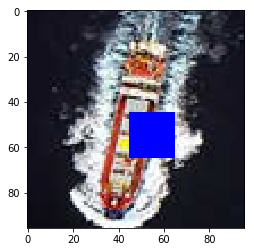

(96, 96)


In [14]:
import matplotlib.pyplot as plt
from PIL import Image

file = '/opt/data/private/stl10_matlab/test_attack/0/b9_1879.png'
img = Image.open(file)
plt.imshow(img)
plt.show()
print(img.size)

In [15]:
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder

from torchvision import transforms
from PIL import Image

def get_loader(root, trans, batch, shuffle=True):
    dataset = ImageFolder(root, trans)
    return DataLoader(dataset, batch, shuffle, num_workers=8)

data_transform = {
        'train': transforms.Compose(
            [
                transforms.Resize((224, 224), interpolation=Image.NEAREST),
                transforms.ToTensor()

            ]
        ),
        'test': transforms.Compose(
            [
                transforms.Resize((224, 224), interpolation=Image.NEAREST),
                transforms.ToTensor()

            ]
        )
    }
load_train = get_loader(r'/opt/data/private/stl10_matlab/train', data_transform['train'], batch=256)
load_test = get_loader(r'/opt/data/private/stl10_matlab/test', data_transform['test'], batch=500, shuffle=False)
load_test_attack = get_loader(r'/opt/data/private/stl10_matlab/test_attack', data_transform['test'], batch=500, shuffle=False)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class Trainer:

    def __init__(self, model, best_acc=0.8, save_model=None):

        self.model = model.to('cuda')
        self.best_acc = best_acc
        self.save_model = save_model
        self.criterion = nn.CrossEntropyLoss()
        self.optim = optim.Adam(self.model.parameters(), lr=0.001)

    def test(self, loader):

        self.model.eval()
        total = 0
        correct = 0
        loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(loader):
                inputs, labels = inputs.to('cuda'), labels.to('cuda')
                total += labels.size(0)
                outputs = self.model(inputs)
                loss += self.criterion(outputs, labels).item()
                predict = torch.max(outputs, dim=1)[1]
                correct += torch.eq(predict, labels).sum().item()

        acc = correct / total
        if self.save_model is not None:
            if acc > self.best_acc:
                self.best_acc = acc
                torch.save(self.model.state_dict(), self.save_model)
        return loss / len(loader), correct / total

    def train(self, loader):

        self.model.train()
        loss = 0.0
        total = 0
        correct = 0

        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = self.model(inputs)
            self.optim.zero_grad()
            loss_step = self.criterion(outputs, labels)
            loss_step.backward()
            self.optim.step()
            loss += loss_step.item()
            predict = torch.max(outputs, dim=1)[1]
            correct += torch.eq(predict, labels).sum().item()
            total += labels.size(0)

        # self.scheduler.step()
        acc = correct / total
        loss /= len(loader)

        return loss, acc

In [20]:
import time
import torch
import random
import numpy as np
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)
torch.cuda.empty_cache()
acc_train = []
acc_test = []
asr = []
epoch = []
trainer = Trainer(model)
for e in range(100):

    print(f'Epoch: {e}')
    epoch.append(e)
    time.sleep(0.01)
    loss, acc = trainer.train(load_train)
    print(f'train loss: {loss:.2f}\t acc: {acc:.2f}')
    time.sleep(0.01)
    loss, acc = trainer.test(load_test)
    acc_test.append(acc)
    print(f'test loss: {loss:.2f}\t acc: {acc:.2f}')
    time.sleep(0.01)
    loss, acc = trainer.test(load_test_attack)
    asr.append(acc)
    print(f'asr: {acc:.2f}')

Epoch: 0


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.05	 acc: 0.98


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


test loss: 0.89	 acc: 0.80


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 1


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


train loss: 0.02	 acc: 0.99


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


test loss: 0.55	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 2


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


train loss: 0.02	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


test loss: 0.80	 acc: 0.82


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 0.99
Epoch: 3


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


test loss: 0.59	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 0.99
Epoch: 4


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


test loss: 0.62	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


asr: 1.00
Epoch: 5


100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


test loss: 0.62	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 6


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


test loss: 0.75	 acc: 0.84


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


asr: 1.00
Epoch: 7


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


test loss: 1.08	 acc: 0.81


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


asr: 1.00
Epoch: 8


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.02	 acc: 0.99


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


test loss: 0.92	 acc: 0.81


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 0.99
Epoch: 9


100%|██████████| 20/20 [00:09<00:00,  2.14it/s]


train loss: 0.03	 acc: 0.99


100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


test loss: 0.85	 acc: 0.82


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 0.96
Epoch: 10


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


train loss: 0.04	 acc: 0.99


100%|██████████| 16/16 [00:06<00:00,  2.29it/s]


test loss: 1.31	 acc: 0.75


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


asr: 0.98
Epoch: 11


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


train loss: 0.04	 acc: 0.99


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


test loss: 0.86	 acc: 0.82


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


asr: 1.00
Epoch: 12


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.03	 acc: 0.99


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


test loss: 0.84	 acc: 0.81


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 13


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.02	 acc: 0.99


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


test loss: 0.69	 acc: 0.84


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


asr: 1.00
Epoch: 14


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


test loss: 0.76	 acc: 0.84


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


asr: 0.99
Epoch: 15


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


test loss: 0.64	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 1.00
Epoch: 16


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


test loss: 0.69	 acc: 0.84


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


asr: 0.99
Epoch: 17


100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


test loss: 0.81	 acc: 0.83


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 0.99
Epoch: 18


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


test loss: 0.61	 acc: 0.86


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 0.99
Epoch: 19


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.01	 acc: 1.00


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


test loss: 0.69	 acc: 0.85


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


asr: 1.00
Epoch: 20


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


test loss: 0.66	 acc: 0.85


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 21


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.26it/s]


test loss: 0.57	 acc: 0.87


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


asr: 1.00
Epoch: 22


100%|██████████| 20/20 [00:09<00:00,  2.11it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


test loss: 0.56	 acc: 0.87


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 1.00
Epoch: 23


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.28it/s]


test loss: 0.51	 acc: 0.88


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


asr: 1.00
Epoch: 24


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


test loss: 0.50	 acc: 0.88


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 25


100%|██████████| 20/20 [00:09<00:00,  2.12it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.52	 acc: 0.88


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 26


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


test loss: 0.49	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 27


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.49	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 28


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


test loss: 0.49	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


asr: 1.00
Epoch: 29


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


test loss: 0.49	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 30


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


asr: 1.00
Epoch: 31


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.10it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 1.00
Epoch: 32


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 33


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


asr: 1.00
Epoch: 34


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


asr: 1.00
Epoch: 35


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 36


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


asr: 1.00
Epoch: 37


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


asr: 1.00
Epoch: 38


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 39


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


asr: 1.00
Epoch: 40


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:08<00:00,  1.98it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


asr: 1.00
Epoch: 41


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 42


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.25it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


asr: 1.00
Epoch: 43


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 44


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


asr: 1.00
Epoch: 45


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


asr: 1.00
Epoch: 46


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 47


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


asr: 1.00
Epoch: 48


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:08<00:00,  2.00it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


asr: 1.00
Epoch: 49


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 50


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 51


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


asr: 1.00
Epoch: 52


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


asr: 1.00
Epoch: 53


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 54


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


asr: 1.00
Epoch: 55


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 56


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


asr: 1.00
Epoch: 57


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 58


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 59


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


asr: 1.00
Epoch: 60


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


asr: 1.00
Epoch: 61


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


asr: 1.00
Epoch: 62


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 63


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


asr: 1.00
Epoch: 64


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


asr: 1.00
Epoch: 65


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


asr: 1.00
Epoch: 66


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:08<00:00,  1.99it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 67


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


asr: 1.00
Epoch: 68


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 69


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


asr: 1.00
Epoch: 70


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 71


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.13it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 72


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


asr: 1.00
Epoch: 73


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


asr: 1.00
Epoch: 74


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 75


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


asr: 1.00
Epoch: 76


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


asr: 1.00
Epoch: 77


100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 78


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


asr: 1.00
Epoch: 79


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 80


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


asr: 1.00
Epoch: 81


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 82


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.08it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


asr: 1.00
Epoch: 83


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 84


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.03it/s]


test loss: 0.47	 acc: 0.90


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


asr: 1.00
Epoch: 85


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 86


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


asr: 1.00
Epoch: 87


100%|██████████| 20/20 [00:09<00:00,  2.09it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.19it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 88


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.04it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


asr: 1.00
Epoch: 89


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.07it/s]


test loss: 0.48	 acc: 0.90


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


asr: 1.00
Epoch: 90


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


asr: 1.00
Epoch: 91


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


asr: 1.00
Epoch: 92


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.09it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


asr: 1.00
Epoch: 93


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.12it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


asr: 1.00
Epoch: 94


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


asr: 1.00
Epoch: 95


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.17it/s]


test loss: 0.47	 acc: 0.90


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


asr: 1.00
Epoch: 96


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.05it/s]


test loss: 0.47	 acc: 0.90


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


asr: 1.00
Epoch: 97


100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.14it/s]


test loss: 0.47	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 98


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


test loss: 0.48	 acc: 0.90


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


asr: 1.00
Epoch: 99


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


train loss: 0.00	 acc: 1.00


100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


test loss: 0.48	 acc: 0.89


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

asr: 1.00


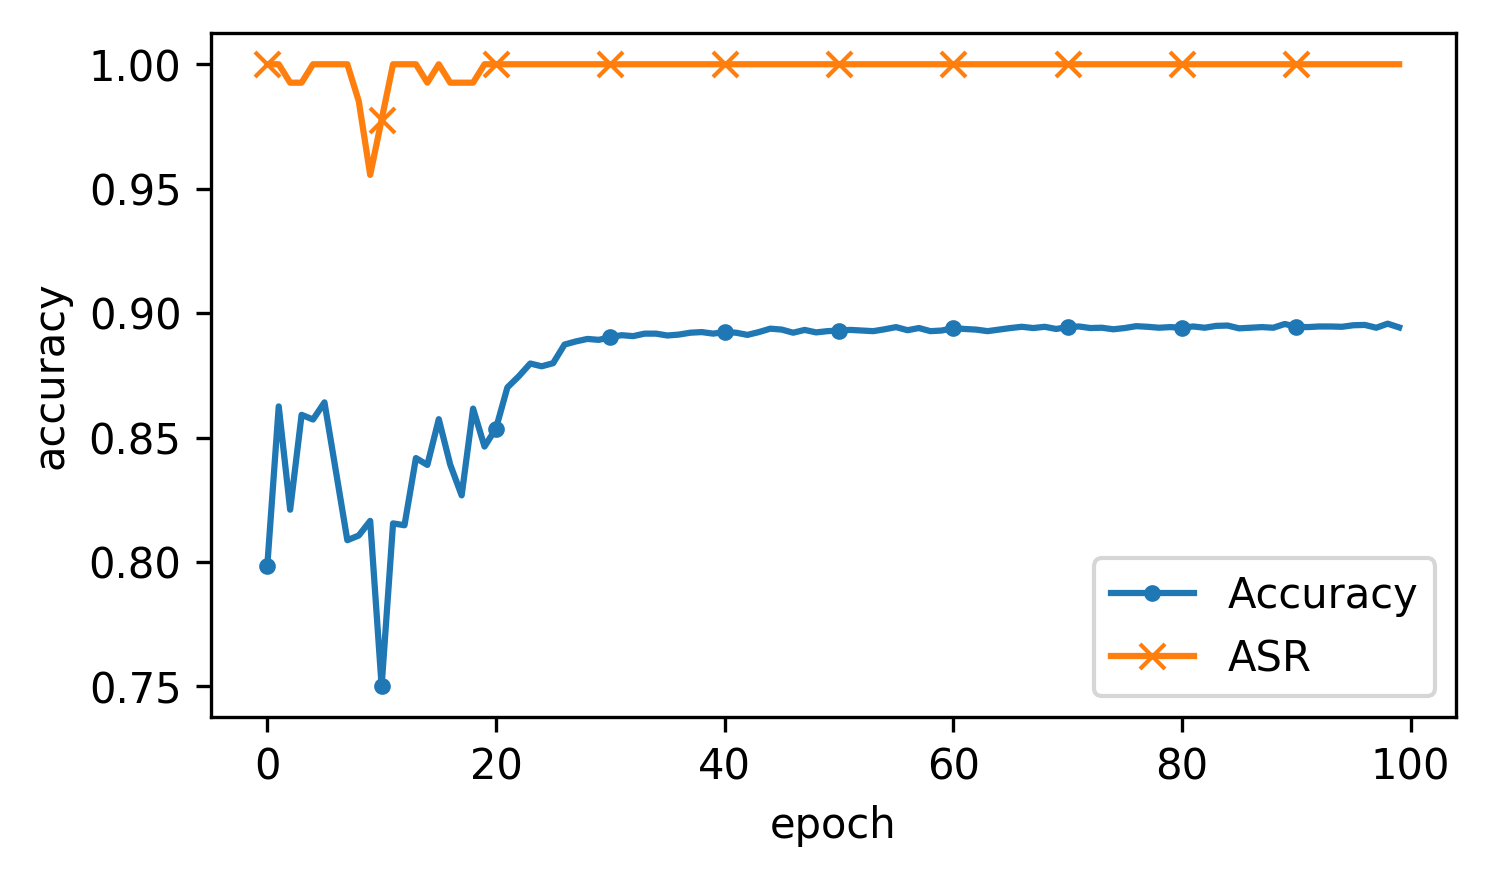

In [22]:
import random

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Avoiding the trouble of color picking.
color = list(colors.TABLEAU_COLORS.keys())
marker = ['.', 'x', 'd']

def plot_train_process(epoch: list, acc: dict, name):

    fig = plt.figure(dpi=300, figsize=(5, 3))
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('epoch', fontsize=10)

    color_index = 0
    ax1.set_ylabel('accuracy', fontsize=10)
    for i, (key, value) in enumerate(acc.items()):
        ax1.plot(epoch, value, color=color[color_index], label=key, marker=marker[i], markevery=10)
        color_index += 1

    fig.subplots_adjust(top=0.93, bottom=0.17, left=0.12, right=0.95)
    plt.legend(loc=4, bbox_transform=ax1.transAxes, prop={'size': 10})

    plt.savefig(name)
    plt.show()

plot_train_process(epoch, {'Accuracy': acc_test, 'ASR': asr}, name='/opt/data/private/stl.eps')